In [1]:
using InteractiveUtils, Pkg, Revise
versioninfo(); Pkg.status()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Gold 6238R CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, cascadelake)
      Status `/scratches/euclid/kx216/proj/AdvancedHMC.jl/test/experimental/Project.toml`
  [0bf59076] AdvancedHMC v0.4.0 `../..`
  [d330b81b] PyPlot v2.11.0
  [37e2e3b7] ReverseDiff v1.14.4
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl.git#main`


In [2]:
import PyPlot; const plt = PyPlot
using Random, LinearAlgebra, Statistics, ReverseDiff, VecTargets, AdvancedHMC
includet("../../src/experimental/riemannian_hmc.jl")

┌ Warning: skipping callee #step#7 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils /homes/kx216/.julia/packages/LoweredCodeUtils/0oUEK/src/signatures.jl:292


In [3]:
# Fisher information metric
function gen_∂H∂x(func, x; f=identity)
    hess = VecTargets.gen_hess(func, ReverseDiff.track.(x))
    # QUES What's the best output format of this function?
    return x -> ReverseDiff.jacobian(x -> f(hess(x)[3]), x) # default output shape [∂H∂x₁; ∂H∂x₂; ...]
end

function reshape_H(H)
    d = size(H, 2)
    return cat((H[(i-1)*d+1:i*d,:] for i in 1:d)...; dims=3)
end

function sample_target(hps; rng=MersenneTwister(1110))    
    target = hps.target == :gaussian  ? HighDimGaussian(2) :
             hps.target == :banana    ? Banana() :
             hps.target == :funnel    ? Funnel() :
             hps.target == :funnel101 ? Funnel(101) :
             hps.target == :spiral    ? Spiral(8, 0.1) :
             hps.target == :mogs      ? TwoDimGaussianMixtures() :
             @error "Unknown target $(hps.target)"
    D = dim(target)
    initial_θ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, x)
    _∂ℓπ∂θ = gen_logpdf_grad(target, initial_θ)
    ∂ℓπ∂θ = x -> copy.(_∂ℓπ∂θ(x))
    
    neg_ℓπ = x -> -logpdf(target, x)
    _hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ) # x -> (value, gradient, hessian)
    hess_func = x -> copy.(_hess_func(x))
    
    G = x -> begin
        H = hess_func(x)[3] + hps.λ * I
        any(.!(isfinite.(H))) ? diagm(ones(length(x))) : H
    end
    _∂G∂θ = gen_∂H∂x(neg_ℓπ, initial_θ)
    ∂G∂θ = x -> reshape_H(copy(_∂G∂θ(x)))

    metric = hps.metric == :dense_euclidean          ? DenseEuclideanMetric(D) :
             hps.metric == :dense_riemannian         ? DenseRiemannianMetric((D,), G, ∂G∂θ) :
             hps.metric == :dense_riemannian_softabs ? DenseRiemannianMetric((D,), G, ∂G∂θ, SoftAbsMap(hps.α)) :
             @error "Unknown metric $(hps.metric)"
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = hps.integrator == :lf  ? Leapfrog(hps.ϵ) :
                 hps.integrator == :glf ? GeneralizedLeapfrog(hps.ϵ, hps.n) :
                 @error "Unknown integrator $(hps.integrator)"

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, initial_θ, hps.n_samples; progress=false, verbose=true
    )
    
    return (; target, hamiltonian, samples, stats)
end

sample_target (generic function with 1 method)

Baseline: HMC with dense but identity Euclidean metric

In [4]:
hps = (; target=:gaussian, n_samples=2_000, metric=:dense_euclidean, λ=1e-2, α=20.0, integrator=:lf, ϵ=0.1, n=6, L=8)
retval = sample_target((; hps...))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.047168153 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, Leapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=Leapfrog(ϵ=0.1), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1186237187225354
│   average_acceptance_rate = 0.9990870349279157
└ @ AdvancedHMC /scratches/euclid/kx216/proj/AdvancedHMC.jl/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059172875182715856, 0.020223117668237246]
│   var(retval.samples) = [0.9466621835679574, 0.9267189667568049]
└ @ Main In[4]:4


Check if generalized leapfrog works fine

In [5]:
retval = sample_target((; hps..., integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.120654782 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1186237187225354
│   average_acceptance_rate = 0.9990870349279157
└ @ AdvancedHMC /scratches/euclid/kx216/proj/AdvancedHMC.jl/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059172875182715856, 0.020223117668237246]
│   var(retval.samples) = [0.9466621835679574, 0.9267189667568049]
└ @ Main In[5]:3


Check if RHMC (with Fisher metric) works (on Gaussian)

In [6]:
@time retval = sample_target((; hps..., metric=:dense_riemannian, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

 61.040825 seconds (650.40 M allocations: 26.406 GiB, 9.85% gc time, 18.95% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 53.313988365 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1194710428834218
│   average_acceptance_rate = 0.9990997411969952
└ @ AdvancedHMC /scratches/euclid/kx216/proj/AdvancedHMC.jl/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059494248703613806, 0.0203247508084654]
│   var(retval.samples) = [0.9465345660813427, 0.9260461275621712]
└ @ Main In[6]:3


Check if RHMC (with Fisher metric) works for Neal's funnel

In [7]:
using Logging: NullLogger, with_logger

@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian, integrator=:glf))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

Check if RHMC with SoftAbs works for Gaussian

In [8]:
@time retval = sample_target((; hps..., metric=:dense_riemannian_softabs, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

 53.750917 seconds (639.06 M allocations: 25.841 GiB, 10.63% gc time, 12.79% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 47.200712859 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1194710428834218
│   average_acceptance_rate = 0.9990997411969952
└ @ AdvancedHMC /scratches/euclid/kx216/proj/AdvancedHMC.jl/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059494248703613806, 0.0203247508084654]
│   var(retval.samples) = [0.9465345660813427, 0.9260461275621712]
└ @ Main In[8]:3


Check if RHMC with SoftAbs works for Neal's funnel

155.619224 seconds (1.46 G allocations: 57.909 GiB, 7.56% gc time, 2.82% compilation time)


┌ Info: Average acceptance ratio
│   mean(map((s->begin
                #= In[9]:5 =#
                s.is_accept
            end), retval.stats)) = 0.5805
└ @ Main In[9]:5


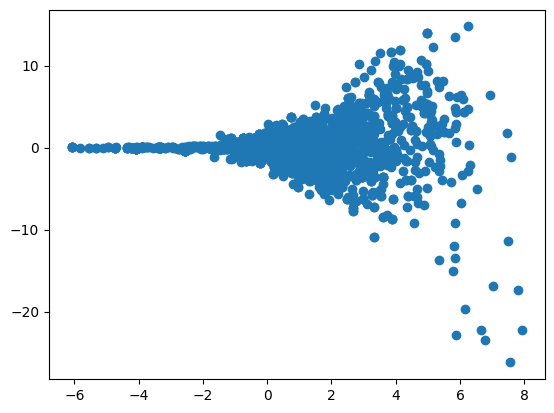

In [9]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf)) # ϵ=0.1
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

In [ ]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf, ϵ=0.05))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

In [ ]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf, ϵ=0.02))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

Check if the Hessian is (semi)-PD for Neal's funnel

In [ ]:
using LinearAlgebra: issuccess

isposdef_pivot(A) = issuccess(cholesky(A, Val(true), check=false))

# Check which region gives non-positive definite for Neal's funnel
let target = Funnel(), 
    rng = MersenneTwister(1110), 
    λ = 0.0
    
    D = dim(target)
    initial_θ = rand(rng, D)
    neg_ℓπ = x -> -logpdf(target, x)
    hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ)
    
    is = -6:0.1:+2
    js = -4:0.1:+4
    X = Matrix{Float64}(undef, length(is), length(js))
    Y = Matrix{Float64}(undef, length(is), length(js))
    logdensity = Matrix{Float64}(undef, length(is), length(js))
    PD = Matrix{Bool}(undef, length(is), length(js))
    for (i, iv) in enumerate(is), (j, jv) in enumerate(js)
        v, _, H = hess_func([iv, jv])
        X[i,j] = iv
        Y[i,j] = jv
        logdensity[i,j] = exp(-v)
        # PD[i,j] = isposdef(H + λ * I)
        PD[i,j] = isposdef_pivot(H + λ * I)
    end
    
    PDvec = vec(PD)
    fig, ax = plt.subplots(figsize=(6, 6)); plt.close(fig)
    ax.contour(X, Y, logdensity, alpha=0.7)
    ax.scatter(vec(X)[PDvec.==0], vec(Y)[PDvec.==0], marker=".", c="C0", alpha=0.7, label="non-PD")
    ax.scatter(vec(X)[PDvec.==1], vec(Y)[PDvec.==1], marker=".", c="C1", alpha=0.7, label="PD")
    ax.axis("equal")
    ax.legend(loc="lower right")
    
    fig
end